# 从0开始的DCNN-BatchNorm
批量规范化(Batch Normalization)
在每次训练迭代中，我们首先**规范化输入**，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。 接下来，我们应用比例系数和比例偏移。 正是由于这个基于批量统计的标准化，才有了批量规范化的名称。只有使用足够大的小批量，批量规范化这种方法才是有效且稳定的。 请注意，在应用批量规范化时，**批量大小**的选择可能比没有批量规范化时更重要。这是一种流行且有效的技术，可持续加速深层网络的收敛速度。 再结合在 7.6节中将介绍的残差块，批量规范化使得研究人员能够训练100层以上的网络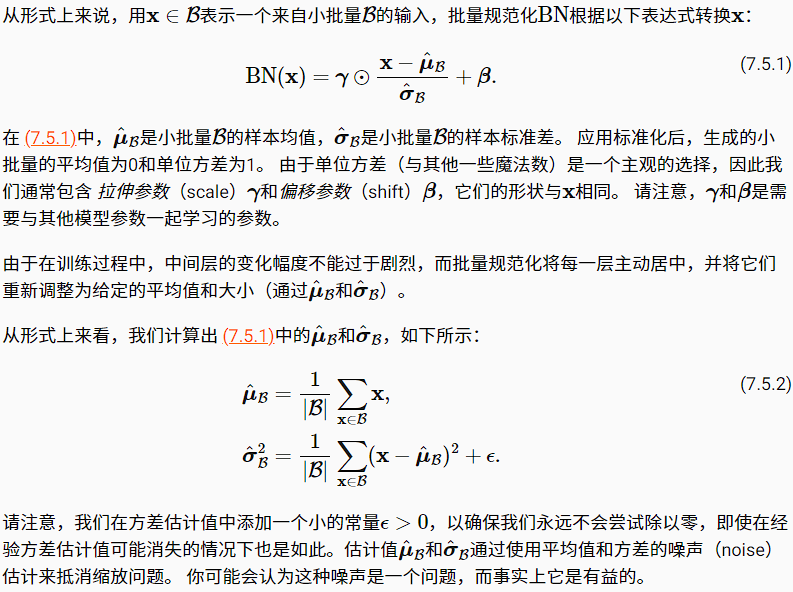

In [1]:
import torch
from torch import nn
import sys
sys.path.append("../")
from MyUtils import d2laiUtils as d2l

In [24]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X-moving_mean)/torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape) in (2, 4) # 输入要么是2维要么4维
        if len(X.shape) == 2: # 全连接层的二维输入
            mean = X.mean(dim=0)
            var = ((X-mean)**2).mean(dim=0)
        else: # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum*moving_mean+(1-momentum)*mean
        moving_var = momentum*moving_var+(1-momentum)*var
    Y = gamma*X_hat
    return Y, moving_mean.data, moving_var.data

In [25]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        if num_dims == 4:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [26]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.761, train acc 0.729, test acc 0.792
loss 0.501, train acc 0.817, test acc 0.789
loss 0.433, train acc 0.844, test acc 0.803
loss 0.400, train acc 0.855, test acc 0.722
loss 0.367, train acc 0.866, test acc 0.855
loss 0.345, train acc 0.875, test acc 0.785
loss 0.329, train acc 0.880, test acc 0.840
loss 0.318, train acc 0.883, test acc 0.867
loss 0.305, train acc 0.889, test acc 0.833
loss 0.297, train acc 0.892, test acc 0.814

34726.8 examples/sec on cuda:0


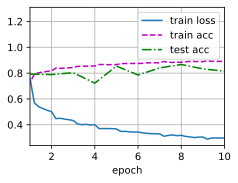

In [27]:
lr, num_epochs, batch_size, gpu = 1.0, 10, 256, torch.device("cuda:0")
train_iter, test_iter = d2l.loadFashionMnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, gpu)

In [28]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.4841, 3.3712, 1.8734, 3.8780, 2.0670, 3.4011], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([0., 0., 0., 0., 0., 0.], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))